In [1]:
### main pipeline for data preprocessing

In [2]:
import numpy as np
import pandas as pd
import math
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

## Pipeline Architecture

### Data-Preprocessing architecture

<ol>
    <li> Generate some form of similarity between Laws using pretrained models such as word2vec or glove. </li>
    <li> Perform Knn clustering for all laws based on (1) </li>
    <li> From m clusters generated by (2) where m = number of laws / k neighbors, load up set of keys for each cluster indicated by a dictionary appended to the cluster. For example, cluster 0 with k laws indicated by a list of dictionary should have a key for all associated keys within cluster 0 consisting of meta-data for each law such as year + state.</li>
    <li> From (3), load up all occurances in the technology descriptors for cluster i as a list. </li>
    <li> From (4), measure changes based on some metric of interest.</li>
    <li> Classify (4) as +1 (excitatory) or 0 (inhibitory). </li>
    <li> Repeat (4) and (5) for all clusters and append the label to the refined dataset. </li>    
</ol>


### Model Pipeline

<ol>
    <li> Obtain a dataset with features corresponding to law text, some technology descriptors, corresponding labels, and a user input metric of interest. </li>
    <li> Train the Model. </li>
    <li> Run Attributions. </li>
    <li> In parallel, run ACC tests on (1) </li>
    <li> Publish the model. </li>
</ol>

In [3]:
### Similarity Matrix generation - 1

In [4]:
df_laws = pd.read_csv('law_data.csv', index_col=False)
df_laws = df_laws.dropna()
del df_laws['Unnamed: 0']

### 1. Law text embeddings

In [5]:
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
import re
from nltk.stem.porter import *
stemmer = PorterStemmer()
import os
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

#### Clean and preprocess policy texts

In [6]:
def law_to_words(raw_review):
    
    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    #letters_only = re.sub("[^a-zA-Z0-9]", " ", raw_review)
    
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 3. Remove Stopwords. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops]  #returns a list 

    # 5. Stem words. Need to define porter stemmer above
    #singles = [stemmer.stem(word) for word in meaningful_words]
    
    # 6. Join the words back into one string separated by space, and return the result.
    return( " ".join(meaningful_words))

In [7]:
df_clean = pd.DataFrame([law_to_words(str(text)) for text in df_laws['StateCode'].tolist()], columns=['texts'])

#### tf-idf values for future weighting

In [8]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df_clean.texts)
tfidf_vectors = tfidf_vectorizer.transform(df_clean.texts)

#### Calculate GloVe embeddings

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [10]:
# tokenize and pad each law to make them of equal size

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_clean.texts)
tokenized_documents = tokenizer.texts_to_sequences(df_clean.texts)
tokenized_paded_documents = pad_sequences(tokenized_documents,maxlen=None,padding='post')
vocab_size = len(tokenizer.word_index) + 1
print(len(tokenized_paded_documents))

826


In [11]:
# reading Glove word embeddings into a dictionary with "word" as key and values as word vectors
embeddings_index = dict()

In [12]:
with open('glove.6B.100d.txt', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(len(embeddings_index))

400000


In [13]:
# creating embedding matrix, every row is a vector representation from the vocabulary indexed by the tokenizer index. 

embedding_matrix = np.zeros((vocab_size,100))

In [14]:
# for word,i in tokenizer.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

In [15]:
# calculating average of word vectors of a document weighted by tf-idf

document_embeddings = np.zeros((len(tokenized_paded_documents),100))
words = tfidf_vectorizer.get_feature_names()

print(len(words))

4520


In [16]:
# # instead of creating document-word embeddings, directly creating document embeddings

# #print(len(tokenizer.word_index))
# #print(tfidf_vectors[0, 2341])

# for i in range(df_clean.shape[0]):
#     for j in range(len(words)):
#         document_embeddings[i] += embedding_matrix[tokenizer.word_index[words[j]]]*tfidf_vectors[i,j]

In [17]:
# calculate cosine similarity and euclidean distance pairwise

pairwise_similarities = cosine_similarity(document_embeddings)
pairwise_differences = euclidean_distances(document_embeddings)

In [18]:
residue = pairwise_similarities - pairwise_differences

In [19]:
LAWS = np.array(df_laws)

In [20]:
matrix = pairwise_similarities

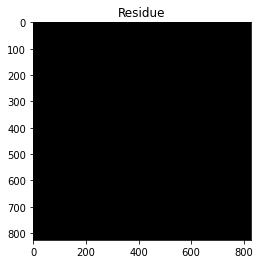

In [21]:
plt.title("Residue")
plt.imshow(residue, cmap='gray')
plt.show()

In [22]:
### TF-IDF (comment it out!)
vect = TfidfVectorizer(min_df=1, stop_words="english", encoding='latin-1')
state_codes = df_laws.StateCode
tfidf = vect.fit_transform(state_codes)
pairwise_similarity = tfidf * tfidf.T
document_embeddings = pairwise_similarity.toarray()

In [23]:
df_laws.head()

,Header,State,Year,Title,Category,Topic,Summary,StateCode
0,Ala. Code 37-16-1 et seq.,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Competition and regulation,Topic: Cooperatives,Allows electric utilities to also provide broa...,(a) To the extent not otherwise authorized by ...
1,Ala. Code 37-16-2,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Other,Topic: Legislative intent,Declares that the state intends to encourage t...,(a) The Legislature finds and declares the fol...
2,Ala. Code 37-16-3,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Definitions,Topic: Definition - Broadband (As defined by F...,"Defines ""advanced communications capabilities""...",(l) Advanced Communications Capabilities. The ...
3,Ala. Code 37-16-3,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Definitions,Topic: Definition - Broadband (Other speed),Defines broadband as an internet connection th...,(5) Broadband Services. The provision of conne...
4,Ala. Code 37-16-7,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Infrastructure access,Topic: Right of way (Easements),Specifies the terms under which a property own...,(a) If the owner of an interest in real proper...


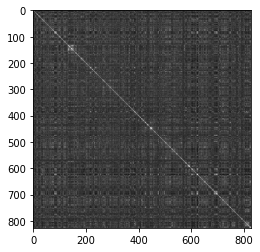

In [24]:
#correlation matrix on document embedding - Minh
plt.imshow(np.corrcoef(document_embeddings.T), 'gray')
plt.show()

In [25]:
### Clustering - 2

In [26]:
K = 20 #number of datapoints per subset - not the same as knn!

In [27]:
def get_cluster(index, data, k):
    """Generates an index cluster of size (k+1) on a similarity dataset of shape nxn with index of interest"""
    sorted_indices = np.argsort(-data[index])
    return sorted_indices[1:k+1] #returns a cluster of indices from `data`

In [28]:
def knn(data, k):
    """Runs the Knn algorithm with k neighbors where each cluster is of size k+1 on a similarity dataset of nxn"""
    clusters = []
    for i,_ in enumerate(data):
        clusters.append(get_cluster(i, data, k))
    return np.array(clusters)

In [29]:
clusters = knn(matrix, K) #generate neighborhood clusters, each of size K

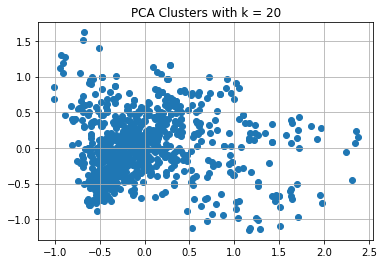

In [30]:
### PCA for feature selection
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(document_embeddings)

plt.title(f"PCA Clusters with k = {K}")
plt.scatter(principalComponents.T[0], principalComponents.T[1])
plt.grid()
plt.show()

In [31]:
### Subsectioning - 3

In [32]:
metric_of_interest = 'broadband data' #user-defined
df = pd.read_csv('../technology_descriptors/broadband-Table 1.csv', index_col=False)

In [33]:
### Measure change in features - 5

In [34]:
def measure_change(data, arr):
    """Measures net change for an individual state and returns a net gain/loss value"""
    net = 0
    for i in range(1, len(data)):
        prev, curr = float(data[i-1][:-1]), float(data[i][:-1])
        net += curr - prev
        arr[-1].append(prev)
    return int(net) #net measures overall change

In [35]:
def gains(data, arr):
    """Computes gain for all states"""
    data = np.array(data.loc[::])
    net_change = []
    for row in data:
        graph_trend.append([])
        net_change.append(measure_change(row[2:], arr))

    #averaging makes no sense! half points 0, other half 1. mode better alternative.
    #need to relax conditions and perform duality of points for comparison.
    net_change = np.array(net_change)
    tau = stats.mode(net_change)[0]
    net_change[net_change <= tau] = 0
    net_change[net_change > tau] = 1

    return np.array(net_change)

In [36]:
graph_trend = []
net_change = gains(df, graph_trend)

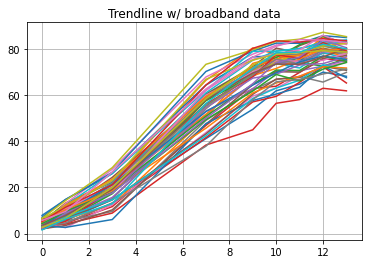

In [37]:
plt.title(f"Trendline w/ {metric_of_interest}")
plt.plot(np.array(graph_trend).T)
plt.grid()
plt.show()

In [38]:
df['change'] = net_change

In [39]:
df.head()

,state,abbreviation,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,change
0,Alabama,AL,2.1%,5.5%,10.2%,14.8%,21.4%,28.0%,34.6%,41.2%,47.6%,53.9%,61.9%,64.8%,70.0%,68.2%,70.4%,0
1,Alaska,AK,4.8%,13.3%,17.9%,22.5%,33.5%,44.5%,55.5%,66.5%,73.5%,80.5%,77.8%,77.0%,82.7%,82.3%,85.8%,1
2,Arizona,AZ,5.2%,12.9%,17.7%,22.5%,30.7%,38.9%,47.1%,55.3%,62.5%,69.6%,78.3%,74.2%,72.6%,75.8%,78.2%,0
3,Arkansas,AR,1.9%,4.5%,8.8%,13.2%,20.3%,27.4%,34.5%,41.6%,49.3%,57.1%,59.5%,65.6%,72.4%,65.3%,69.0%,0
4,California,CA,5.8%,12.1%,17.4%,22.7%,31.7%,40.6%,49.5%,58.5%,64.2%,69.9%,75.4%,75.1%,79.6%,80.2%,82.7%,0


In [40]:
### generate subset - 4

In [41]:
def get_subset(data, cluster):
    """
    Generates a subset of technology descriptors based on a cluster of laws. The output is change on states.
    - data: dataframe object coresponding to tech descriptor.
    - cluster: list of indices corresponding to LAWS array.
    """
    subset = {}
    num_pos = 0
    for index in cluster:
        #this assumes that there exists only 1 tech. descriptor per state
        change = np.array(data.loc[data.state == LAWS[index][1]]['change'])[0]
        subset[LAWS[index][1]] = change
        if change:
            num_pos += 1
    return subset, num_pos > K - num_pos #subsets, cluster label

In [42]:
#### Classify all laws as +1/0 - 6 & 7

In [43]:
def label_data(data, num_laws, subsets):
    """Labels all laws as Excitatory or Inhibitory based on some technology descriptor `data`."""
    labels = [-1]*num_laws #-1 indicates laws with no label. will not exist
    for subset in subsets:
        _, label = get_subset(data, subset)
        for i in subset:
            labels[i] = label
    return np.array(labels).reshape(num_laws, 1)

In [44]:
labels = label_data(df, len(LAWS), clusters)

In [45]:
LAWS = np.column_stack((LAWS, labels)) ### all laws labeled

In [46]:
df_labeled_laws = pd.DataFrame(LAWS, columns=list(df_laws.columns) + ['label'])

In [47]:
df_labeled_laws = df_labeled_laws[df_labeled_laws.label != -1] #remove all unlabeled laws

In [48]:
df_labeled_laws.head()

,Header,State,Year,Title,Category,Topic,Summary,StateCode,label
544,66 Pa.C.S. 3014 (d),Pennsylvania,2004,Business attraction or retention program,Category: Competition and regulation,Topic: Service provision (SP) - Other,Requires local exchange carriers to participat...,(1) Not later than 90 days after amending its ...,0
545,66 Pa.C.S. 3014 (h),Pennsylvania,2004,Prohibition against political subdivision adva...,Category: Competition and regulation,Topic: Municipal broadband,Prohibits a local jurisdiction from providing ...,(1) Except as otherwise provided for under par...,0
546,66 Pa.C.S. 3014 (m),Pennsylvania,2004,Inventory of available services,Category: Broadband programs,Topic: Mapping,Requires the Department of Economic and Commun...,"(1) The department shall compile, periodically...",0
547,66 Pa.C.S. 3015 (a),Pennsylvania,2004,Alternative forms of regulation,Category: Competition and regulation,Topic: Service provision (SP) - Other,Sets inflation offset within the telecommunica...,(1) Except as otherwise provided in paragraphs...,0
548,66 Pa.C.S. 3015 (c),Pennsylvania,2004,Broadband Outreach and Aggregation Fund,Category: Funding and financing,Topic: Fund - Broadband,Establishes the Broadband Outreach and Aggrega...,(1) There is hereby established within the Sta...,0


In [49]:
def update_colors(labels):
    colors = labels.T[0].astype(str)
    colors[colors == '1'] = 'green'
    colors[colors == '-1'] = 'red'
    colors[colors == '0'] = 'yellow'
    return colors

In [50]:
color_labels = update_colors(labels)

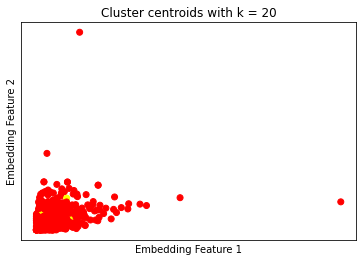

In [51]:
plt.title(f"Cluster centroids with k = {K}")
plt.scatter(document_embeddings.T[0], document_embeddings.T[1], 
            c=color_labels)
plt.xlabel('Embedding Feature 1')
plt.ylabel('Embedding Feature 2')

plt.xticks(ticks=[])
plt.yticks(ticks=[])

plt.show()

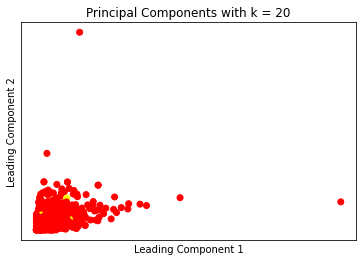

In [52]:
### PCA for feature selection
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(document_embeddings)

plt.title(f"Principal Components with k = {K}")
plt.scatter(document_embeddings.T[0], document_embeddings.T[1], c=color_labels)
plt.xlabel('Leading Component 1')
plt.ylabel('Leading Component 2')

plt.xticks(ticks=[])
plt.yticks(ticks=[])

plt.show()

In [53]:
counter = [0]*3
for y in labels:
    counter[y[0] + 1] += 1
print(f"Label undefined: {counter[0]}\nInhibitory: {counter[1]}\nExcitatory: {counter[2]}")

Label undefined: 806
Inhibitory: 20
Excitatory: 0


In [54]:
### DONE. Annotation

> Note: Dropped unlabelled laws.

#### Input:

- Law text (processed to glove representation)
- State
- Year
- Env. Descriptor (e.g. area, land, population, age, state funds) [Unique to State, not laws]

Input:
<p> law_representation, state, year, funds - mean 5yr, population - mean 5yr, area - mean 5yr, land - mean 5yr </p>

Train model on this. Run attribution on this model to evaluate key features for prediction. Output: XAI

In [55]:
### Model Pipeline
###### code

### Attribution Add-on
###### sync code

In [56]:
y = labels[np.where(labels != -1)[0]].squeeze()
X = document_embeddings[y].squeeze()

In [57]:
from sklearn.model_selection import train_test_split
import torch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [59]:
X_train = torch.tensor(X_train, requires_grad=True)
X_test = torch.tensor(X_test, requires_grad=True)
y_train = torch.tensor(y_train, requires_grad=True)
y_test = torch.tensor(y_test, requires_grad=True)

In [60]:
torch.save([X_train, y_train], '../../attribution/data/laws/train_dp_tensor.pth')

In [61]:
torch.save([X_test, y_test], '../../attribution/data/laws/test_dp_tensor.pth')